# Part 1: PINNs for Burgers' Equation

The following libraries will be necessary for your implementation. Ensure you have them installed before proceeding.

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
from pyDOE import lhs  # Latin Hypercube Sampling for colocation points
import scipy
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Set default data type for tensors to float32
torch.set_default_dtype(torch.float)
dtype = torch.float

# Set random seeds for reproducibility
torch.manual_seed(1234)
np.random.seed(1234)

### Data preparation

You will load the numerical solution of the Burgers’ equation and prepare training data for the PINN. The data consists of spatial grid points (x), time points (t), and the corresponding solution (usol).

**Task 1: Create the meshgrid**
* Use np.meshgrid to generate the grid for spatial and time points from x and t. The meshgrid will be used for plotting and defining boundary conditions.

In [2]:
# Load numerical solution data from the file
data = scipy.io.loadmat('Data/burgers_shock_mu_01_pi.mat')
x = data['x']  # Spatial grid points (256 points between -1 and 1)
t = data['t']  # Time grid points (100 points between 0 and 1)
usol = data['usol']  # Solution matrix of shape (256, 100)

# Create a meshgrid from x and t arrays
X, T = np.meshgrid(x, t)

# Define the domain bounds
lower_bound = np.array([X.min(), T.min()])  # [x_min, t_min] = [-1, 0]
upper_bound = np.array([X.max(), T.max()])  # [x_max, t_max] = [1, 0.99]

In [3]:
def solution_plot(u_pred, usol, x, t, X, T, X_u_train, u_train):
    
    fig = plt.figure(figsize=(9, 9))  # Adjust the figure size
    gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1])
    fig.subplots_adjust(hspace=0.4)  # Add more space between subplots

    # Plot u(x, t)
    ax = plt.subplot(gs[0])
    h = ax.imshow(u_pred, interpolation='nearest', cmap='rainbow', 
                  extent=[T.min(), T.max(), X.min(), X.max()], 
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    ax.plot(X_u_train[:, 1], X_u_train[:, 0], 'kx', 
            label='Data (%d points)' % u_train.shape[0], 
            markersize=4, clip_on=False)
    
    for time_step in [25, 50, 75]:
        ax.plot(t[time_step] * np.ones((2, 1)), np.linspace(x.min(), x.max(), 2), 
                'w-', linewidth=1)
    
    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc='upper right')
    ax.set_title('$u(x,t)$ - PINN solution', fontsize=12)

    # Plot error
    ax = plt.subplot(gs[1])
    error = np.abs(usol - u_pred)
    h = ax.imshow(error, interpolation='nearest', cmap='rainbow', 
                  extent=[T.min(), T.max(), X.min(), X.max()], 
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    ax.plot(X_u_train[:, 1], X_u_train[:, 0], 'kx', 
            label='Data (%d points)' % u_train.shape[0], 
            markersize=4, clip_on=False)
    
    for time_step in [25, 50, 75]:
        ax.plot(t[time_step] * np.ones((2, 1)), np.linspace(x.min(), x.max(), 2), 
                'w-', linewidth=1)
    
    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc='best')
    ax.set_title('Error', fontsize=12)

    # u(x,t) slices
    gs2 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[2], wspace=0.5)
    
    time_steps = [25, 50, 75]
    titles = ['$t = 0.25s$', '$t = 0.50s$', '$t = 0.75s$']
    
    for i, time_step in enumerate(time_steps):
        ax = plt.subplot(gs2[0, i])
        ax.plot(x, usol.T[time_step, :], 'b-', linewidth=2, label='Exact')       
        ax.plot(x, u_pred.T[time_step, :], 'r--', linewidth=2, label='Prediction')
        ax.set_xlabel('$x$')
        ax.set_ylabel('$u(x,t)$')    
        ax.set_xlim([-1.1, 1.1])
        ax.set_ylim([-1.1, 1.1])
        ax.set_title(titles[i], fontsize=10)
        ax.axis('square')

        if i == 1:
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=2, frameon=False)

    plt.show()

/var/folders/qd/0yh2jh4n7yl69tzm4y8kdnkh0000gn/T/ipykernel_74949/862890114.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(frameon=False, loc='upper right')


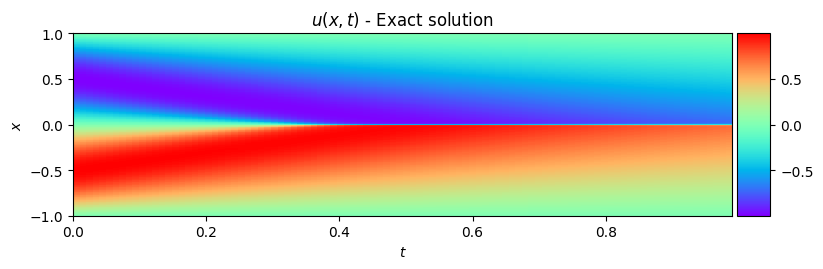

In [4]:
def plot_exact_solution(usol, X, T):

    fig = plt.figure(figsize=(9, 9))  # Adjust the figure size
    gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1])
    fig.subplots_adjust(hspace=0.4)  # Add more space between subplots

    # Plot u(x, t)
    ax = plt.subplot(gs[0])
    h = ax.imshow(usol, interpolation='nearest', cmap='rainbow', 
                  extent=[T.min(), T.max(), X.min(), X.max()], 
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc='upper right')
    ax.set_title('$u(x,t)$ - Exact solution', fontsize=12)

    plt.show()

plot_exact_solution(usol, X, T)

In this section, you will define the training data from boundary and initial conditions. A portion of the code has been removed, and you’ll need to complete it.

**Task 2: Define Boundary Conditions**
* Define boundary conditions for x = -1 and x = 1 across the time domain.

**Task 3: Select Random Training Points**
* Randomly select N_u points from the combined dataset to create the training set. Use np.random.choice to select the indices and extract corresponding values for Xt_u_train and u_train.

In [5]:
# Generate training data (boundary and initial conditions)
N_u = 100  # Number of boundary condition points
N_f = 10_000  # Number of colocation points

# Initial condition: -1 <= x <= 1, t = 0
initial_condition_xt = np.hstack((X[0, :][:, None], T[0, :][:, None]))
initial_condition_u = usol[:, 0][:, None]

# TODO: Boundary condition: x = -1, 0 <= t <= 1
boundary_left_xt = np.hstack((X[:, 0][:, None], T[:, 0][:, None]))
boundary_left_u = usol[0, :][:, None]

# TODO: Boundary condition: x = 1, 0 <= t <= 1
boundary_right_xt = np.hstack((X[:, -1][:, None], T[:, -1][:, None]))
boundary_right_u = usol[-1, :][:, None]

# Combine boundary and initial condition points
all_xt_u_train = np.vstack([initial_condition_xt, boundary_left_xt, boundary_right_xt])
all_u_train = np.vstack([initial_condition_u, boundary_left_u, boundary_right_u])

# TODO: Select N_u random points for training
selected_indices = np.random.choice(all_u_train.shape[0], N_u, replace=False)
Xt_u_train = all_xt_u_train[selected_indices, :]
u_train = all_u_train[selected_indices, :]


**Task 4: Generate Collocation Points**
* Use lhs (Latin Hypercube Sampling) to generate collocation points in the domain. Combine the generated points with the boundary condition points.

In [6]:
# TODO: Generate colocation points using Latin Hypercube Sampling
Xt_f_train = lower_bound + lhs(2, N_f) * (upper_bound - lower_bound)
Xt_f_train = np.vstack((Xt_f_train, Xt_u_train))  # Append boundary points to colocation points

### PINN architecture

A basic architecture for the Physics-Informed Neural Network is provided. Review the structure and complete the training loop in the next section.

In [7]:
# Define the physics-informed neural network (PINN) class
class PINN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super().__init__()
        
        # Initialize layers list
        layers = []
        current_dim = input_dim

        # Build hidden layers with Xavier initialization
        for _ in range(num_layers):
            linear_layer = nn.Linear(current_dim, hidden_dim)
            nn.init.xavier_normal_(linear_layer.weight)
            layers.append(linear_layer)
            layers.append(nn.Tanh())
            current_dim = hidden_dim
        
        # Add output layer
        layers.append(nn.Linear(hidden_dim, output_dim))
        
        # Create the sequential model
        self.model = nn.Sequential(*layers)

    # Define forward pass through the network
    def forward(self, x):
        return self.model(x)

**Task 5: Instantiate the PINN Model**
* Define the dimensions (input_dim, hidden_dim, output_dim, num_layers) for the network and instantiate the PINN model.

In [8]:
# TODO: Instantiate the PINN model
pinn_model = PINN(
    input_dim=2,  # 2D input (x, t)
    hidden_dim=32,  # Hidden layer size
    output_dim=1,  # Output (u)
    num_layers=8  # Number of hidden layers
)

# Display the neural network architecture
print(pinn_model)

PINN(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Tanh()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): Tanh()
    (8): Linear(in_features=32, out_features=32, bias=True)
    (9): Tanh()
    (10): Linear(in_features=32, out_features=32, bias=True)
    (11): Tanh()
    (12): Linear(in_features=32, out_features=32, bias=True)
    (13): Tanh()
    (14): Linear(in_features=32, out_features=32, bias=True)
    (15): Tanh()
    (16): Linear(in_features=32, out_features=1, bias=True)
  )
)


Let's convert the data to tensors

In [9]:
# Convert data to PyTorch tensors
Xt_f_train = torch.from_numpy(Xt_f_train).float()
Xt_u_train = torch.from_numpy(Xt_u_train).float()
u_train = torch.from_numpy(u_train).float()
f_hat = torch.zeros(Xt_f_train.shape[0], 1)

### Train PINN 

**Task 6: Compute the PDE Residual Loss**
* Compute the PDE residual loss using automatic differentiation (torch.autograd.grad). You’ll need to calculate first and second derivatives of u with respect to x and t and then define the PDE residual (f_residual).


In [10]:
# Set up the optimizer
optimizer = torch.optim.Adam(pinn_model.parameters(), lr=0.001)
max_iterations = 2000

# Record the starting time
start_time = time.time()

# Define the viscosity term
viscosity_nu = 0.01 / np.pi

# Training loop for PINN
for iteration in range(max_iterations):
    optimizer.zero_grad()

    # Compute the loss for boundary conditions
    u_pred_train = pinn_model(Xt_u_train)
    loss_u = F.mse_loss(u_pred_train, u_train)

    # Compute the PDE residual loss using automatic differentiation
    Xt_f_train.requires_grad = True
    u_pred_collocation = pinn_model(Xt_f_train)
    
    # TODO: Compute first and second derivatives w.r.t. x and t
    u_grad = torch.autograd.grad(u_pred_collocation,Xt_f_train,grad_outputs=torch.ones_like(u_pred_collocation),create_graph=True)[0]
    u_x = u_grad[:, [0]]
    u_t = u_grad[:, [1]]
    u_xx = torch.autograd.grad(
        outputs=u_x,
        inputs=Xt_f_train,
        grad_outputs=torch.ones_like(u_x),
        create_graph=True
    )[0][:, [0]]
    
    # TODO: Compute the PDE residual
    f_residual = u_t + u_pred_collocation * u_x - viscosity_nu * u_xx
    loss_f = F.mse_loss(f_residual, f_hat)

    # Combine losses and backpropagate
    total_loss = loss_u + loss_f
    total_loss.backward()
    
    # Print the loss every 100 iterations
    if (iteration + 1) % 100 == 0:
        print(f"Iteration {iteration+1}/{max_iterations}, Loss: {total_loss.item()}")

    # Perform optimization step
    optimizer.step()

Iteration 100/2000, Loss: 0.09041003882884979
Iteration 200/2000, Loss: 0.056333765387535095
Iteration 300/2000, Loss: 0.04445261135697365
Iteration 400/2000, Loss: 0.03276391327381134
Iteration 500/2000, Loss: 0.02647770382463932
Iteration 600/2000, Loss: 0.018568575382232666
Iteration 700/2000, Loss: 0.036688726395368576
Iteration 800/2000, Loss: 0.0067604174837470055
Iteration 900/2000, Loss: 0.004017939791083336
Iteration 1000/2000, Loss: 0.0029415092431008816
Iteration 1100/2000, Loss: 0.002497716573998332
Iteration 1200/2000, Loss: 0.0023452285677194595
Iteration 1300/2000, Loss: 0.0020745459478348494
Iteration 1400/2000, Loss: 0.001956238644197583
Iteration 1500/2000, Loss: 0.0013771059457212687
Iteration 1600/2000, Loss: 0.0013889279216527939
Iteration 1700/2000, Loss: 0.06291045248508453
Iteration 1800/2000, Loss: 0.0018964207265526056
Iteration 1900/2000, Loss: 0.0010965485125780106
Iteration 2000/2000, Loss: 0.0009131385013461113


### Test the PINN

After training, test the model and compute the relative L2 error between the predicted and true solutions.
To get full credits in this part, you will need to get a **test error below 0.3**.


In [11]:
# Prepare the test data
Xt_u_test = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_true = usol.flatten('F')[:, None]

Xt_u_test = torch.from_numpy(Xt_u_test).float()
u_true = torch.from_numpy(u_true).float()

# Predict u using the trained PINN model
u_pred_test = pinn_model(Xt_u_test)

# Calculate the relative L2 error between predicted and true values
error_vector = torch.linalg.norm((u_true - u_pred_test), 2) / torch.linalg.norm(u_true, 2)
print(f"Test Error: {error_vector.item():.5f}")


Test Error: 0.08241


### Plot the solution

Finally, visualize the solution by plotting the predicted vs. true solution of the Burgers’ equation.

In [12]:
def solution_plot(u_pred, usol, x, t, X, T, X_u_train, u_train):
    
    fig = plt.figure(figsize=(9, 9))  # Adjust the figure size
    gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1])
    fig.subplots_adjust(hspace=0.4)  # Add more space between subplots

    # Plot u(x, t)
    ax = plt.subplot(gs[0])
    h = ax.imshow(u_pred, interpolation='nearest', cmap='rainbow', 
                  extent=[T.min(), T.max(), X.min(), X.max()], 
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    ax.plot(X_u_train[:, 1], X_u_train[:, 0], 'kx', 
            label='Data (%d points)' % u_train.shape[0], 
            markersize=4, clip_on=False)
    
    for time_step in [25, 50, 75]:
        ax.plot(t[time_step] * np.ones((2, 1)), np.linspace(x.min(), x.max(), 2), 
                'w-', linewidth=1)
    
    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc='upper right')
    ax.set_title('$u(x,t)$ - PINN solution', fontsize=12)

    # Plot error
    ax = plt.subplot(gs[1])
    error = np.abs(usol - u_pred)
    h = ax.imshow(error, interpolation='nearest', cmap='rainbow', 
                  extent=[T.min(), T.max(), X.min(), X.max()], 
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    ax.plot(X_u_train[:, 1], X_u_train[:, 0], 'kx', 
            label='Data (%d points)' % u_train.shape[0], 
            markersize=4, clip_on=False)
    
    for time_step in [25, 50, 75]:
        ax.plot(t[time_step] * np.ones((2, 1)), np.linspace(x.min(), x.max(), 2), 
                'w-', linewidth=1)
    
    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc='best')
    ax.set_title('Error', fontsize=12)

    # u(x,t) slices
    gs2 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[2], wspace=0.5)
    
    time_steps = [25, 50, 75]
    titles = ['$t = 0.25s$', '$t = 0.50s$', '$t = 0.75s$']
    
    for i, time_step in enumerate(time_steps):
        ax = plt.subplot(gs2[0, i])
        ax.plot(x, usol.T[time_step, :], 'b-', linewidth=2, label='Exact')       
        ax.plot(x, u_pred.T[time_step, :], 'r--', linewidth=2, label='Prediction')
        ax.set_xlabel('$x$')
        ax.set_ylabel('$u(x,t)$')    
        ax.set_xlim([-1.1, 1.1])
        ax.set_ylim([-1.1, 1.1])
        ax.set_title(titles[i], fontsize=10)
        ax.axis('square')

        if i == 1:
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=2, frameon=False)

    plt.show()

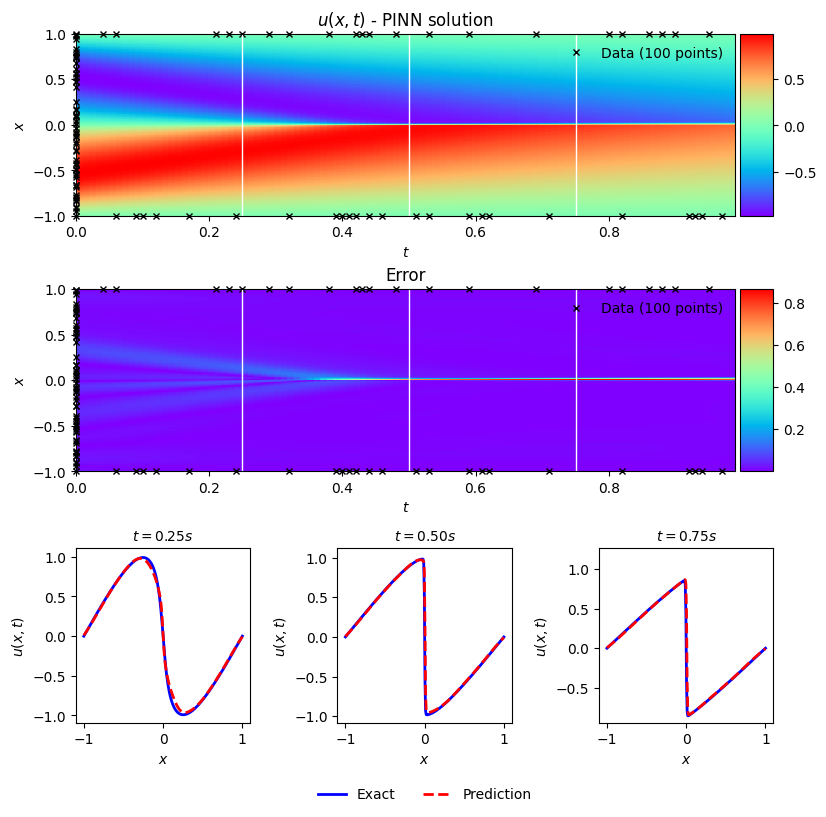

In [13]:
# Plot the solution
solution_plot(u_pred_test.cpu().detach().numpy().reshape((256, 100), order='F'), 
                 usol, x, t, X, T, Xt_u_train.cpu().detach().numpy(),u_train.cpu().detach().numpy())

# Part 2: PINNs for Reaction-diffusion equation

/var/folders/qd/0yh2jh4n7yl69tzm4y8kdnkh0000gn/T/ipykernel_74949/862890114.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(frameon=False, loc='upper right')


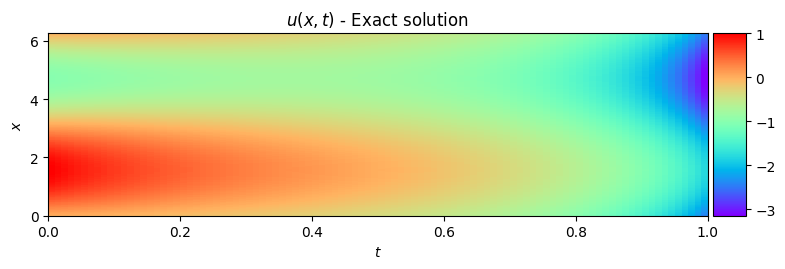

In [14]:
def function(u0: str):
    """Initial condition, string --> function."""

    if u0 == 'sin(x)':
        u0 = lambda x: np.sin(x)
    elif u0 == 'sin(pix)':
        u0 = lambda x: np.sin(np.pi*x)
    elif u0 == 'sin^2(x)':
        u0 = lambda x: np.sin(x)**2
    elif u0 == 'sin(x)cos(x)':
        u0 = lambda x: np.sin(x)*np.cos(x)
    elif u0 == '0.1sin(x)':
        u0 = lambda x: 0.1*np.sin(x)
    elif u0 == '0.5sin(x)':
        u0 = lambda x: 0.5*np.sin(x)
    elif u0 == '10sin(x)':
        u0 = lambda x: 10*np.sin(x)
    elif u0 == '50sin(x)':
        u0 = lambda x: 50*np.sin(x)
    elif u0 == '1+sin(x)':
        u0 = lambda x: 1 + np.sin(x)
    elif u0 == '2+sin(x)':
        u0 = lambda x: 2 + np.sin(x)
    elif u0 == '6+sin(x)':
        u0 = lambda x: 6 + np.sin(x)
    elif u0 == '10+sin(x)':
        u0 = lambda x: 10 + np.sin(x)
    elif u0 == 'sin(2x)':
        u0 = lambda x: np.sin(2*x)
    elif u0 == 'tanh(x)':
        u0 = lambda x: np.tanh(x)
    elif u0 == '2x':
        u0 = lambda x: 2*x
    elif u0 == 'x^2':
        u0 = lambda x: x**2
    elif u0 == 'gauss':
        x0 = np.pi
        sigma = np.pi/4
        u0 = lambda x: np.exp(-np.power((x - x0)/sigma, 2.)/2.)
    return u0

def reaction(u, rho, dt):
    """ du/dt = rho*u*(1-u)
    """
    factor_1 = u * np.exp(rho * dt)
    factor_2 = (1 - u)
    u = factor_1 / (factor_2 + factor_1)
    return u

def diffusion(u, nu, dt, IKX2):
    """ du/dt = nu*d2u/dx2
    """
    factor = np.exp(nu * IKX2 * dt)
    u_hat = np.fft.fft(u)
    u_hat *= factor
    u = np.real(np.fft.ifft(u_hat))
    return u

def reaction_diffusion_discrete_solution(u0 : str, nu, rho, nx = 256, nt = 100):
    """ Computes the discrete solution of the reaction-diffusion PDE using
        pseudo-spectral operator splitting.
    Args:
        u0: initial condition
        nu: diffusion coefficient
        rho: reaction coefficient
        nx: size of x-tgrid
        nt: number of points in the t grid
    Returns:
        u: solution
    """
    L = 2*np.pi
    T = 1
    dx = L/nx
    dt = T/nt
    x = np.arange(0, L, dx) # not inclusive of the last point
    t = np.linspace(0, T, nt).reshape(-1, 1)
    X, T = np.meshgrid(x, t)
    u = np.zeros((nx, nt))
    k = np.fft.fftfreq(nx, d=dx) * 2 * np.pi
    IKX = 1j * k
    IKX2 = IKX * IKX

    # call u0 this way so array is (n, ), so each row of u should also be (n, )
    u0 = function(u0)
    u0 = u0(x)

    u[:,0] = u0
    u_ = u0
    for i in range(nt-1):
        u_ = reaction(u_, rho, dt)
        u_ = diffusion(u_, nu, dt, IKX2)
        u[:,i+1] = u_

    # u = u.T
    # u = u.flatten()
    return u


# Load numerical solution data from the file
L = 2*np.pi
T = 1
dx = L/256
x = np.arange(0, L, dx).reshape(-1, 1) # not inclusive of the last point
t = np.linspace(0, T, 100).reshape(-1, 1)
u0_str = 'sin(x)'
nu = 4.25
rho = 1.75

usol = reaction_diffusion_discrete_solution(u0_str, nu, rho, 256, 100)                         # solution of 256x100 grid points
X, T = np.meshgrid(x,t)  
plot_exact_solution(usol, X, T)

In [15]:
# Define the domain bounds
lower_bound = np.array([X.min(), T.min()])  # [x_min, t_min] = [-1, 0]
upper_bound = np.array([X.max(), T.max()])  # [x_max, t_max] = [1, 0.99]

# Generate training data (boundary and initial conditions)
N_u = 100  # Number of boundary condition points
N_f = 10_000  # Number of colocation points

# TODO: Leverage your previous code for processing this PDE data

# Initial condition: -1 <= x <= 1, t = 0
initial_condition_xt = np.hstack((X[0, :][:, None], T[0, :][:, None]))
initial_condition_u = usol[:, 0][:, None]

# TODO: Boundary condition: x = -1, 0 <= t <= 1
boundary_left_xt = np.hstack((X[:, 0][:, None], T[:, 0][:, None]))
boundary_left_u = usol[0, :][:, None]

# TODO: Boundary condition: x = 1, 0 <= t <= 1
boundary_right_xt = np.hstack((X[:, -1][:, None], T[:, -1][:, None]))
boundary_right_u = usol[-1, :][:, None]

# Combine boundary and initial condition points
all_xt_u_train = np.vstack([initial_condition_xt, boundary_left_xt, boundary_right_xt])
all_u_train = np.vstack([initial_condition_u, boundary_left_u, boundary_right_u])

# TODO: Select N_u random points for training
selected_indices = np.random.choice(all_u_train.shape[0], N_u, replace=False)
Xt_u_train = all_xt_u_train[selected_indices, :]
u_train = all_u_train[selected_indices, :]

Xt_f_train = lower_bound + lhs(2, N_f) * (upper_bound - lower_bound)
Xt_f_train = np.vstack((Xt_f_train, Xt_u_train))  # Append boundary points to colocation points

# Convert data to PyTorch tensors
Xt_f_train = torch.from_numpy(Xt_f_train).float()
Xt_u_train = torch.from_numpy(Xt_u_train).float()
u_train = torch.from_numpy(u_train).float()
f_hat = torch.zeros(Xt_f_train.shape[0], 1)



In [16]:
# TODO: Instantiate the PINN model
pinn_model = PINN(
    input_dim=2,  # 2D input (x, t)
    hidden_dim=32,  # Hidden layer size
    output_dim=1,  # Output (u)
    num_layers=4  # Number of hidden layers
)

# Display the neural network architecture
print(pinn_model)

PINN(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Tanh()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): Tanh()
    (8): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [17]:
# TODO: train PINN

# Set up the optimizer
optimizer = torch.optim.Adam(pinn_model.parameters(), lr=0.001)
max_iterations = 2000

# Record the starting time
start_time = time.time()

# Define the viscosity term
viscosity_nu = 4.25
rho = 1.75

# Training loop for PINN
for iteration in range(max_iterations):
    optimizer.zero_grad()

    # Compute the loss for boundary conditions
    u_pred_train = pinn_model(Xt_u_train)
    loss_u = F.mse_loss(u_pred_train, u_train)

    # Compute the PDE residual loss using automatic differentiation
    Xt_f_train.requires_grad = True
    u_pred_collocation = pinn_model(Xt_f_train)
    
    # TODO: Compute first and second derivatives w.r.t. x and t
    u_grad = torch.autograd.grad(u_pred_collocation,Xt_f_train,grad_outputs=torch.ones_like(u_pred_collocation),create_graph=True)[0]
    u_x = u_grad[:, [0]]
    u_t = u_grad[:, [1]]
    u_xx = torch.autograd.grad(
        outputs=u_x,
        inputs=Xt_f_train,
        grad_outputs=torch.ones_like(u_x),
        create_graph=True
    )[0][:, [0]]
    
    # TODO: Compute the PDE residual
    f_residual = u_t - viscosity_nu * u_xx - rho * u_pred_collocation * (1 - u_pred_collocation)
    loss_f = F.mse_loss(f_residual, f_hat)

    # Combine losses and backpropagate
    total_loss = loss_u + loss_f
    total_loss.backward()
    
    # Print the loss every 100 iterations
    if (iteration + 1) % 100 == 0:
        print(f"Iteration {iteration+1}/{max_iterations}, Loss: {total_loss.item()}")

    # Perform optimization step
    optimizer.step()

Iteration 100/2000, Loss: 0.2627106308937073
Iteration 200/2000, Loss: 0.1503509283065796
Iteration 300/2000, Loss: 0.1284414529800415
Iteration 400/2000, Loss: 0.10976281017065048
Iteration 500/2000, Loss: 0.08816512674093246
Iteration 600/2000, Loss: 0.07117229700088501
Iteration 700/2000, Loss: 0.0884779542684555
Iteration 800/2000, Loss: 0.046205464750528336
Iteration 900/2000, Loss: 0.036430004984140396
Iteration 1000/2000, Loss: 0.04932497814297676
Iteration 1100/2000, Loss: 0.022979937493801117
Iteration 1200/2000, Loss: 0.01876106485724449
Iteration 1300/2000, Loss: 0.014910733327269554
Iteration 1400/2000, Loss: 0.013455487787723541
Iteration 1500/2000, Loss: 0.009539814665913582
Iteration 1600/2000, Loss: 0.00817008689045906
Iteration 1700/2000, Loss: 0.07674980163574219
Iteration 1800/2000, Loss: 0.00604396965354681
Iteration 1900/2000, Loss: 0.005661601200699806
Iteration 2000/2000, Loss: 0.005112928804010153


In [18]:
# Prepare the test data
Xt_u_test = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_true = usol.flatten('F')[:, None]

Xt_u_test = torch.from_numpy(Xt_u_test).float()
u_true = torch.from_numpy(u_true).float()

# Predict u using the trained PINN model
u_pred_test = pinn_model(Xt_u_test)

# Calculate the relative L2 error between predicted and true values
error_vector = torch.linalg.norm((u_true - u_pred_test), 2) / torch.linalg.norm(u_true, 2)
print(f"Test Error: {error_vector.item():.5f}")


Test Error: 0.22116


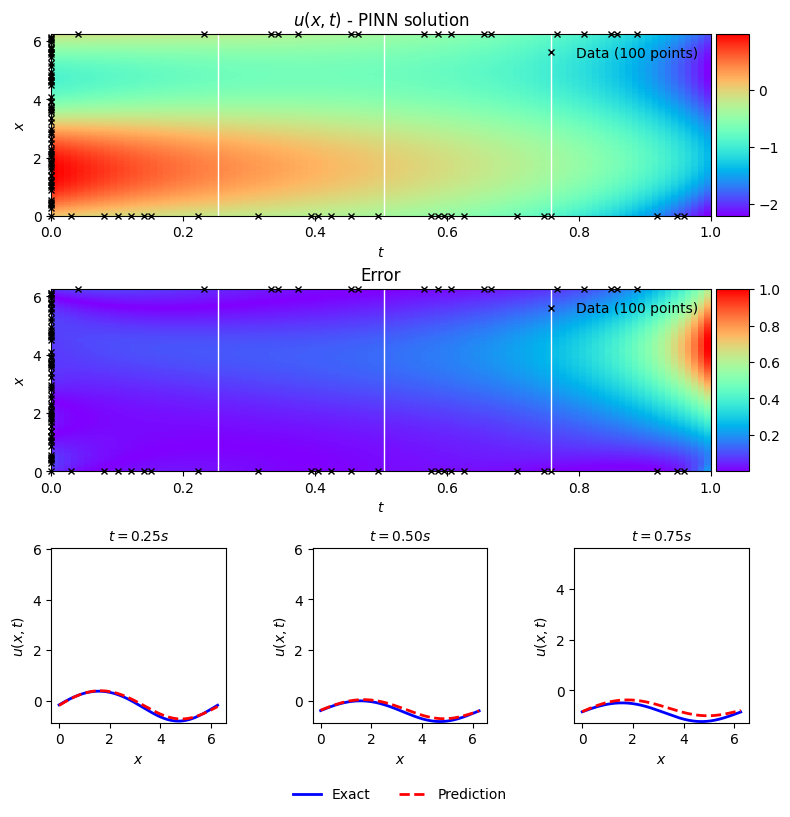

In [19]:
solution_plot(u_pred_test.cpu().detach().numpy().reshape((256, 100), order='F'), 
                 usol, x, t, X, T, Xt_u_train.cpu().detach().numpy(),u_train.cpu().detach().numpy())


# Part 3: Advanced improvements to PINNs

Here we apply curriculum training technique for the Reaction-diffusion equation. We use the exact setup of the model configuration with the following procedure of curriculum learning:

Nu and Rho being: (2,0.75),(3,1.25) and finally (4.25,1.75) as the final parameters we want. We train for 2000 steps each and finally observe that the test error decreases from 0.22 to 0.17.

/var/folders/qd/0yh2jh4n7yl69tzm4y8kdnkh0000gn/T/ipykernel_74949/862890114.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(frameon=False, loc='upper right')


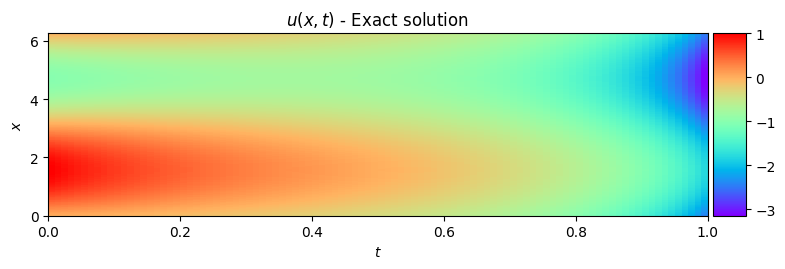

In [20]:
def function(u0: str):
    """Initial condition, string --> function."""

    if u0 == 'sin(x)':
        u0 = lambda x: np.sin(x)
    elif u0 == 'sin(pix)':
        u0 = lambda x: np.sin(np.pi*x)
    elif u0 == 'sin^2(x)':
        u0 = lambda x: np.sin(x)**2
    elif u0 == 'sin(x)cos(x)':
        u0 = lambda x: np.sin(x)*np.cos(x)
    elif u0 == '0.1sin(x)':
        u0 = lambda x: 0.1*np.sin(x)
    elif u0 == '0.5sin(x)':
        u0 = lambda x: 0.5*np.sin(x)
    elif u0 == '10sin(x)':
        u0 = lambda x: 10*np.sin(x)
    elif u0 == '50sin(x)':
        u0 = lambda x: 50*np.sin(x)
    elif u0 == '1+sin(x)':
        u0 = lambda x: 1 + np.sin(x)
    elif u0 == '2+sin(x)':
        u0 = lambda x: 2 + np.sin(x)
    elif u0 == '6+sin(x)':
        u0 = lambda x: 6 + np.sin(x)
    elif u0 == '10+sin(x)':
        u0 = lambda x: 10 + np.sin(x)
    elif u0 == 'sin(2x)':
        u0 = lambda x: np.sin(2*x)
    elif u0 == 'tanh(x)':
        u0 = lambda x: np.tanh(x)
    elif u0 == '2x':
        u0 = lambda x: 2*x
    elif u0 == 'x^2':
        u0 = lambda x: x**2
    elif u0 == 'gauss':
        x0 = np.pi
        sigma = np.pi/4
        u0 = lambda x: np.exp(-np.power((x - x0)/sigma, 2.)/2.)
    return u0

def reaction(u, rho, dt):
    """ du/dt = rho*u*(1-u)
    """
    factor_1 = u * np.exp(rho * dt)
    factor_2 = (1 - u)
    u = factor_1 / (factor_2 + factor_1)
    return u

def diffusion(u, nu, dt, IKX2):
    """ du/dt = nu*d2u/dx2
    """
    factor = np.exp(nu * IKX2 * dt)
    u_hat = np.fft.fft(u)
    u_hat *= factor
    u = np.real(np.fft.ifft(u_hat))
    return u

def reaction_diffusion_discrete_solution(u0 : str, nu, rho, nx = 256, nt = 100):
    """ Computes the discrete solution of the reaction-diffusion PDE using
        pseudo-spectral operator splitting.
    Args:
        u0: initial condition
        nu: diffusion coefficient
        rho: reaction coefficient
        nx: size of x-tgrid
        nt: number of points in the t grid
    Returns:
        u: solution
    """
    L = 2*np.pi
    T = 1
    dx = L/nx
    dt = T/nt
    x = np.arange(0, L, dx) # not inclusive of the last point
    t = np.linspace(0, T, nt).reshape(-1, 1)
    X, T = np.meshgrid(x, t)
    u = np.zeros((nx, nt))
    k = np.fft.fftfreq(nx, d=dx) * 2 * np.pi
    IKX = 1j * k
    IKX2 = IKX * IKX

    # call u0 this way so array is (n, ), so each row of u should also be (n, )
    u0 = function(u0)
    u0 = u0(x)

    u[:,0] = u0
    u_ = u0
    for i in range(nt-1):
        u_ = reaction(u_, rho, dt)
        u_ = diffusion(u_, nu, dt, IKX2)
        u[:,i+1] = u_

    # u = u.T
    # u = u.flatten()
    return u


# Load numerical solution data from the file
L = 2*np.pi
T = 1
dx = L/256
x = np.arange(0, L, dx).reshape(-1, 1) # not inclusive of the last point
t = np.linspace(0, T, 100).reshape(-1, 1)
u0_str = 'sin(x)'
nu = 4.25
rho = 1.75

usol = reaction_diffusion_discrete_solution(u0_str, nu, rho, 256, 100)                         # solution of 256x100 grid points
X, T = np.meshgrid(x,t)  
plot_exact_solution(usol, X, T)

In [21]:
# TODO: Instantiate the PINN model
pinn_model = PINN(
    input_dim=2,  # 2D input (x, t)
    hidden_dim=32,  # Hidden layer size
    output_dim=1,  # Output (u)
    num_layers=4  # Number of hidden layers
)

# Display the neural network architecture
print(pinn_model)

PINN(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Tanh()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): Tanh()
    (8): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [22]:
combinations = [(2,0.75),(3,1.25),(4.25,1.75)]

def generate_points(nu,rho):    
    usol = reaction_diffusion_discrete_solution(u0_str, nu, rho, 256, 100)                         # solution of 256x100 grid points
    # Define the domain bounds
    lower_bound = np.array([X.min(), T.min()])  # [x_min, t_min] = [-1, 0]
    upper_bound = np.array([X.max(), T.max()])  # [x_max, t_max] = [1, 0.99]

    # Generate training data (boundary and initial conditions)
    N_u = 100  # Number of boundary condition points
    N_f = 10_000  # Number of colocation points

    # TODO: Leverage your previous code for processing this PDE data

    # Initial condition: -1 <= x <= 1, t = 0
    initial_condition_xt = np.hstack((X[0, :][:, None], T[0, :][:, None]))
    initial_condition_u = usol[:, 0][:, None]

    # TODO: Boundary condition: x = -1, 0 <= t <= 1
    boundary_left_xt = np.hstack((X[:, 0][:, None], T[:, 0][:, None]))
    boundary_left_u = usol[0, :][:, None]

    # TODO: Boundary condition: x = 1, 0 <= t <= 1
    boundary_right_xt = np.hstack((X[:, -1][:, None], T[:, -1][:, None]))
    boundary_right_u = usol[-1, :][:, None]

    # Combine boundary and initial condition points
    all_xt_u_train = np.vstack([initial_condition_xt, boundary_left_xt, boundary_right_xt])
    all_u_train = np.vstack([initial_condition_u, boundary_left_u, boundary_right_u])

    # TODO: Select N_u random points for training
    selected_indices = np.random.choice(all_u_train.shape[0], N_u, replace=False)
    Xt_u_train = all_xt_u_train[selected_indices, :]
    u_train = all_u_train[selected_indices, :]

    Xt_f_train = lower_bound + lhs(2, N_f) * (upper_bound - lower_bound)
    Xt_f_train = np.vstack((Xt_f_train, Xt_u_train))  # Append boundary points to colocation points

    # Convert data to PyTorch tensors
    Xt_f_train = torch.from_numpy(Xt_f_train).float()
    Xt_u_train = torch.from_numpy(Xt_u_train).float()
    u_train = torch.from_numpy(u_train).float()
    f_hat = torch.zeros(Xt_f_train.shape[0], 1)
    return Xt_f_train,Xt_u_train,u_train,f_hat


for nu,rho in combinations:
    Xt_f_train,Xt_u_train,u_train,f_hat = generate_points(nu,rho)
    optimizer = torch.optim.Adam(pinn_model.parameters(), lr=0.005)

    # TODO: train PINN

    # Set up the optimizer
    max_iterations = 2000
    # Training loop for PINN
    for iteration in range(max_iterations):
        optimizer.zero_grad()

        # Compute the loss for boundary conditions
        u_pred_train = pinn_model(Xt_u_train)
        loss_u = F.mse_loss(u_pred_train, u_train)

        # Compute the PDE residual loss using automatic differentiation
        Xt_f_train.requires_grad = True
        u_pred_collocation = pinn_model(Xt_f_train)
        
        # TODO: Compute first and second derivatives w.r.t. x and t
        u_grad = torch.autograd.grad(u_pred_collocation,Xt_f_train,grad_outputs=torch.ones_like(u_pred_collocation),create_graph=True)[0]
        u_x = u_grad[:, [0]]
        u_t = u_grad[:, [1]]
        u_xx = torch.autograd.grad(
            outputs=u_x,
            inputs=Xt_f_train,
            grad_outputs=torch.ones_like(u_x),
            create_graph=True
        )[0][:, [0]]
        
        # TODO: Compute the PDE residual
        f_residual = u_t - nu * u_xx - rho * u_pred_collocation * (1 - u_pred_collocation)
        loss_f = F.mse_loss(f_residual, f_hat)

        # Combine losses and backpropagate
        total_loss = loss_u + loss_f
        total_loss.backward()
        
        # Print the loss every 100 iterations
        if (iteration + 1) % 100 == 0:
            print(f"Iteration {iteration+1}/{max_iterations}, Loss: {total_loss.item()}")

        # Perform optimization step
        optimizer.step()


Iteration 100/2000, Loss: 0.008535930886864662
Iteration 200/2000, Loss: 0.0008825802942737937
Iteration 300/2000, Loss: 0.0009059006115421653
Iteration 400/2000, Loss: 0.0003892853856086731
Iteration 500/2000, Loss: 0.00037510658148676157
Iteration 600/2000, Loss: 0.00030767876887694
Iteration 700/2000, Loss: 0.0003063717158511281
Iteration 800/2000, Loss: 0.0002569836506154388
Iteration 900/2000, Loss: 0.000263704831013456
Iteration 1000/2000, Loss: 0.0002353600284550339
Iteration 1100/2000, Loss: 0.00019264710135757923
Iteration 1200/2000, Loss: 0.0002997865085490048
Iteration 1300/2000, Loss: 0.0001759022707119584
Iteration 1400/2000, Loss: 0.00012446631444618106
Iteration 1500/2000, Loss: 0.0010161874815821648
Iteration 1600/2000, Loss: 0.00034783268347382545
Iteration 1700/2000, Loss: 0.0004382802580948919
Iteration 1800/2000, Loss: 0.000855466874781996
Iteration 1900/2000, Loss: 0.0010186356958001852
Iteration 2000/2000, Loss: 0.0001662597933318466
Iteration 100/2000, Loss: 0.00

In [23]:
# Prepare the test data
viscosity_nu = 4.25
rho = 1.75
usol = reaction_diffusion_discrete_solution(u0_str, viscosity_nu, rho, 256, 100)                         # solution of 256x100 grid points
Xt_u_test = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_true = usol.flatten('F')[:, None]

Xt_u_test = torch.from_numpy(Xt_u_test).float()
u_true = torch.from_numpy(u_true).float()

# Predict u using the trained PINN model
u_pred_test = pinn_model(Xt_u_test)

# Calculate the relative L2 error between predicted and true values
error_vector = torch.linalg.norm((u_true - u_pred_test), 2) / torch.linalg.norm(u_true, 2)
print(f"Test Error: {error_vector.item():.5f}")


Test Error: 0.17857


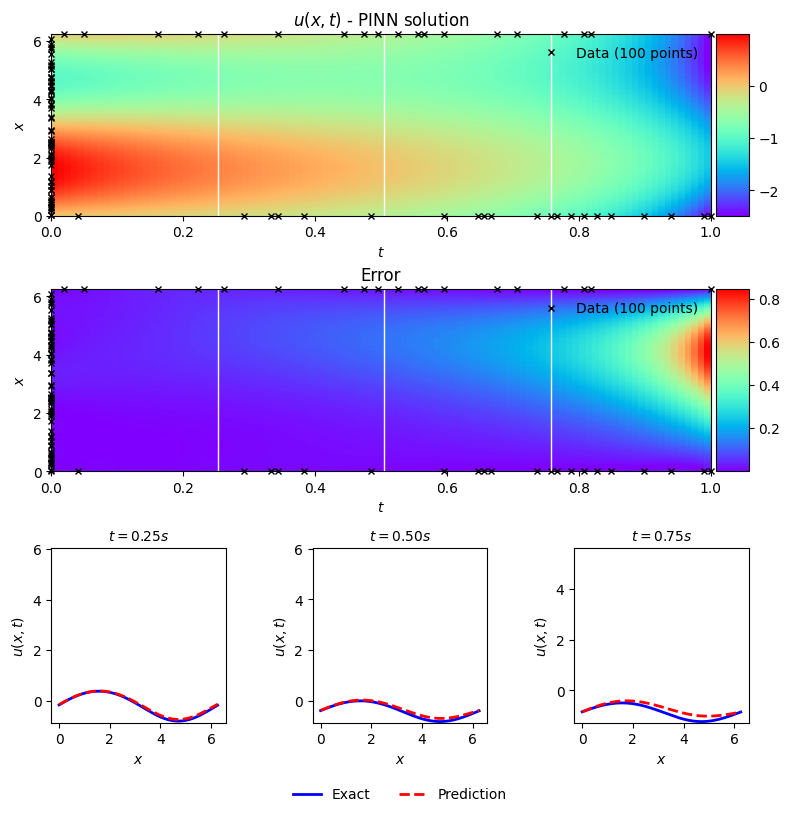

In [24]:
solution_plot(u_pred_test.cpu().detach().numpy().reshape((256, 100), order='F'), 
                 usol, x, t, X, T, Xt_u_train.cpu().detach().numpy(),u_train.cpu().detach().numpy())
